# Przygotowanie modelu

In [7]:
! pip install kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
%%capture
! kaggle datasets download gpiosenka/100-bird-species
! unzip 100-bird-species.zip

In [10]:
!pip install matplotlib==3.4.0
!pip install captum

In [11]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import PIL.Image as Image
from torchvision import datasets,models
import matplotlib.pyplot as plt
from torch.autograd import Variable
import warnings
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
warnings.filterwarnings("ignore")
from tqdm import tqdm
from captum.attr import Lime
from skimage import segmentation
from captum.attr import visualization
from captum.attr import IntegratedGradients
from captum.attr import KernelShap
from captum.attr import Lime

In [12]:
if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"
DEVICE

'cuda:0'

*Source: https://stackoverflow.com/questions/65231299/load-csv-and-image-dataset-in-pytorch*

In [13]:
MAX_CLASS = 40
transform = transforms.Compose([transforms.ToTensor()])
def encode_label(label):
    target = torch.zeros(MAX_CLASS)
    target[int(label)] = 1
    return target

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, dataset, transform = None):
        self.df = pd.read_csv(csv_path)
        self.df = self.df.loc[self.df['data set'] == dataset].reset_index(drop=True)
        self.df = self.df.loc[self.df['class index'] < MAX_CLASS].reset_index(drop=True)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index, "filepaths"]
        label = self.df.loc[index, "class index"]
        image = Image.open(filename)
        if self.transform is not None:
            image = self.transform(image)
        return image, encode_label(label)

    def getlabelitem(self, index):
        filename = self.df.loc[index, "filepaths"]
        label = self.df.loc[index, "labels"]
        image = Image.open(filename)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    def getclassnames(self):
      return pd.unique(self.df.loc[:, "labels"])

train_dataset = CustomDataset("birds.csv", "", "train", transform)
test_dataset = CustomDataset("birds.csv", "", "test", transform)

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

Liczba klas: 40
Wielkość zbioru treningowego: 5980
Wielkość zbioru testowego: 200


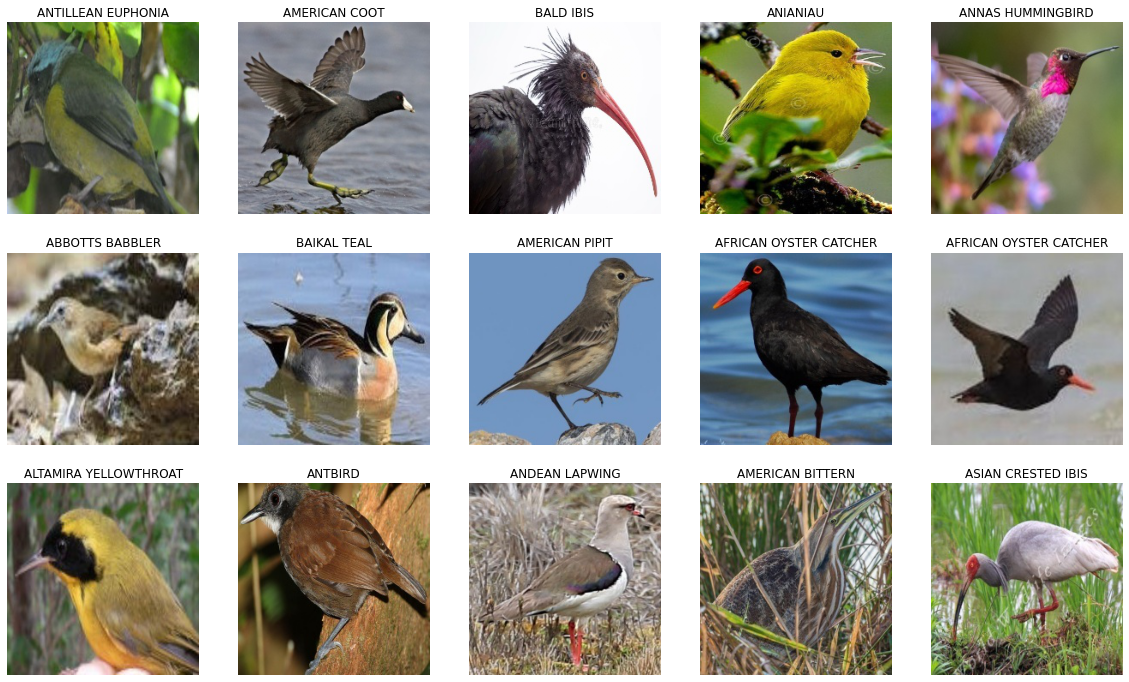

In [14]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

fig, ax = plt.subplots(3, 5, figsize=(20, 12))
for i, a in enumerate(ax.flat):
  image, label = train_dataset.getlabelitem(np.random.randint(len(train_dataset)))
  imshow(image, a, label)

print("Liczba klas:", MAX_CLASS)
print("Wielkość zbioru treningowego:", len(train_dataset))
print("Wielkość zbioru testowego:", len(test_dataset))
plt.show()

*Source: https://blog.jovian.ai/predicting-bird-species-with-pytorch-41ee657e8749*

In [108]:
hackyImages = []
def accuracy(outputs, targets):
    _, preds = torch.max(outputs, dim=1)
    _, encoded_targets = torch.max(targets, dim=1)
    return torch.tensor(torch.sum(preds == encoded_targets).item() / len(preds))

class BirdClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, targets)
        return loss
    
    def validation_step(self, batch):
        images, targets = batch
        out = self(images)
        global hackyImages
        hackyImages = images
        loss = F.binary_cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
              epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))
        
def conv_block(in_chann, out_chann, pool=False):
    layers = [nn.Conv2d(in_chann, out_chann, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_chann),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(4, 4))
    return nn.Sequential(*layers)

class ResNet7(BirdClassificationBase):
    def __init__(self, in_chann=3, out_chann1=64, out_chann2=64, out_chann3=64, out_chann4=256,
                       out_chann5=256, out_chann6=256, in_size=256*7*7, out_size=MAX_CLASS):
        super().__init__()
        self.conv1 = conv_block(in_chann, out_chann1, pool=True)    # output: 64 x 56 x 56
        self.res1 = nn.Sequential(conv_block(out_chann1, out_chann2), conv_block(out_chann2, out_chann3))    # output: 64 x 56 x 56
        
        self.conv3 = conv_block(out_chann3, out_chann4, pool=True)    # output: 256 x 14 x 14
        self.res2 = nn.Sequential(conv_block(out_chann4, out_chann5), conv_block(out_chann5, out_chann6))    # output: 256 x 14 x 14
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2,2),    # output: 256 x 7 x 7
                                        nn.Flatten(),
                                        nn.Linear(in_size, out_size),
                                        nn.Softmax(dim=1))
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out



def get_default_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation step
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def setMasterSeed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)

In [109]:
setMasterSeed(7)

num_epochs = 20
opt_func = torch.optim.SGD
weight_decay = 1e-4
lr = 1e-2

train_dl = DeviceDataLoader(train_loader, DEVICE)
test_dl = DeviceDataLoader(test_loader, DEVICE)
model = to_device(ResNet7(), DEVICE)

history = [evaluate(model, test_dl)]
history += fit_one_cycle(num_epochs, lr, model, train_dl, test_dl, opt_func=opt_func)

Epoch [1], train_loss: 0.1283, val_loss: 0.1163, val_acc: 0.0443
Epoch [2], train_loss: 0.1064, val_loss: 0.0951, val_acc: 0.2539
Epoch [3], train_loss: 0.0881, val_loss: 0.0810, val_acc: 0.3750
Epoch [4], train_loss: 0.0744, val_loss: 0.0634, val_acc: 0.5109
Epoch [5], train_loss: 0.0637, val_loss: 0.0560, val_acc: 0.5820
Epoch [6], train_loss: 0.0552, val_loss: 0.0516, val_acc: 0.6411
Epoch [7], train_loss: 0.0494, val_loss: 0.0457, val_acc: 0.6602
Epoch [8], train_loss: 0.0435, val_loss: 0.0441, val_acc: 0.6888
Epoch [9], train_loss: 0.0389, val_loss: 0.0395, val_acc: 0.7131
Epoch [10], train_loss: 0.0346, val_loss: 0.0384, val_acc: 0.7049
Epoch [11], train_loss: 0.0318, val_loss: 0.0349, val_acc: 0.7522
Epoch [12], train_loss: 0.0289, val_loss: 0.0344, val_acc: 0.7444
Epoch [13], train_loss: 0.0263, val_loss: 0.0342, val_acc: 0.7717
Epoch [14], train_loss: 0.0241, val_loss: 0.0318, val_acc: 0.7895
Epoch [15], train_loss: 0.0224, val_loss: 0.0332, val_acc: 0.7556
Epoch [16], train_l

# Predykcje modelu

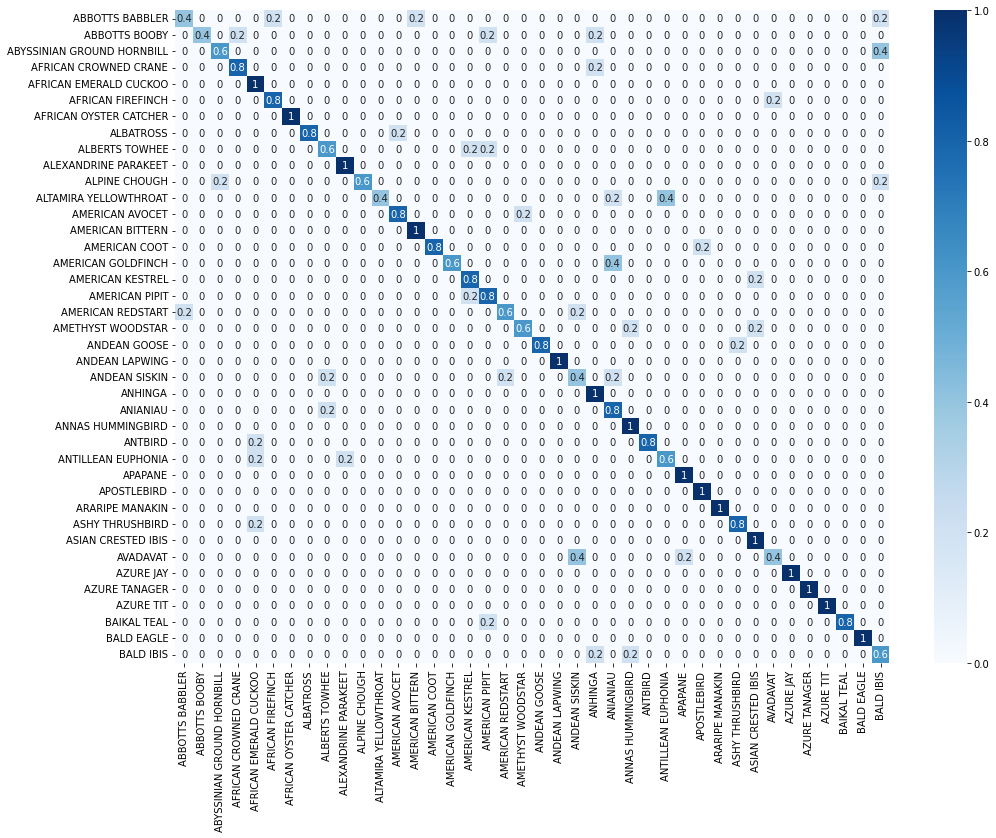

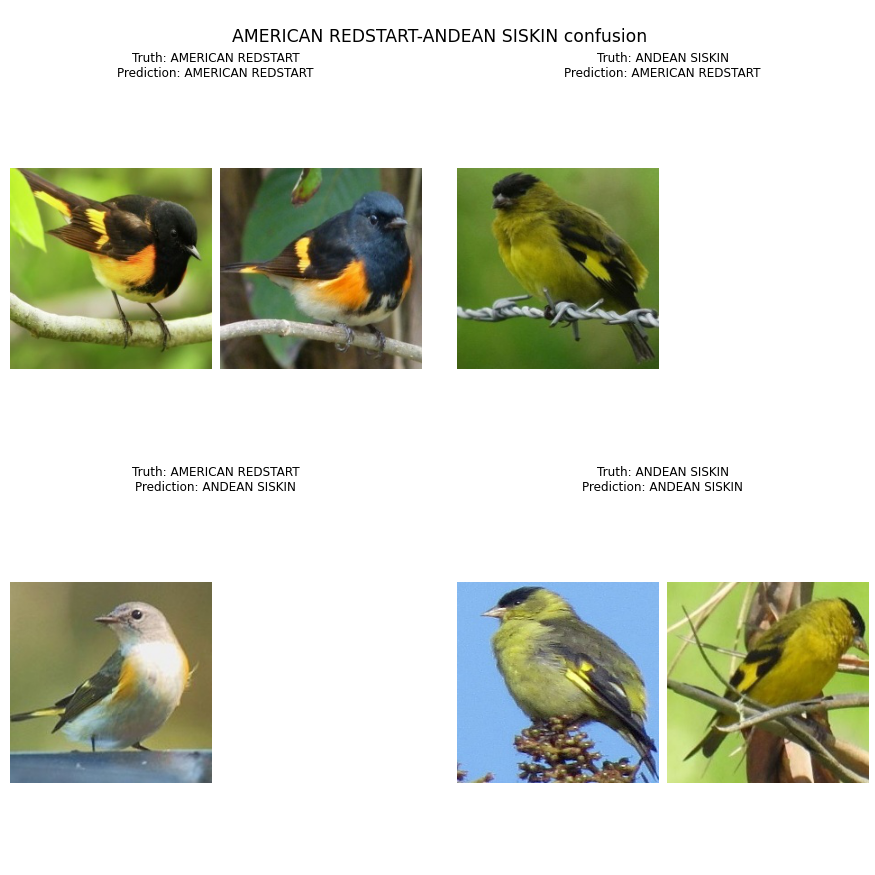

In [110]:
setMasterSeed(7)
def confusionMatrix(man, dataset, classes, explain):
  y_pred = []
  y_true = []
  explanation = [[], [], [], []]

  @torch.no_grad()
  def predict_dl(dl, model):
      torch.cuda.empty_cache()
      inputs = []
      batch_probs = []
      targets = []
      for xb, tgt in dl:
          probs = model(xb)
          inputs.append(xb.cpu().detach())
          targets.append(tgt.cpu().detach())
          batch_probs.append(probs.cpu().detach())
      inputs = torch.cat(inputs)
      batch_probs = torch.cat(batch_probs)
      targets = torch.cat(targets)
      return [(inputs[i], np.argmax(batch_probs[i]), np.argmax(targets[i])) for i in range(len(inputs))]

  
  # iterate over test data
  for inputs, output, labels in predict_dl(dataset, man):
          y_pred.append(output) # Save Prediction
          y_true.append(labels) # Save Truth

          if labels == explain[0]:
            if output == explain[0]:
              explanation[0].append(inputs)
            elif output == explain[1]:
              explanation[2].append(inputs)
          elif labels == explain[1]:
            if output == explain[0]:
              explanation[1].append(inputs)
            elif output == explain[1]:
              explanation[3].append(inputs)

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * len(classes), index = [i for i in classes],
                      columns = [i for i in classes])
  fig = plt.figure(figsize = (16, 12))
  sn.heatmap(df_cm, annot=True, cmap="Blues")
  plt.show()
  

  def sh(i, j):
    return "Truth: "+classes[explain[i]]+"\nPrediction: "+classes[explain[j]]
  fig = plt.figure(constrained_layout=True, figsize=(12, 12))
  fig.suptitle('\n'+classes[explain[0]]+'-'+classes[explain[1]]+" confusion", fontsize='xx-large')
  subfigs = fig.subfigures(2, 2, wspace=0.07)
  subtitles = [sh(0,0),sh(1,0),sh(0,1),sh(1,1)]

  for outerind, subfig in enumerate(subfigs.flat):
      subfig.suptitle(subtitles[outerind])
      axs = subfig.subplots(1, 2, squeeze=False)
      for i in range(len(axs.flat)):
          axs.flat[i].axis('off')
      for i in range(min(len(axs.flat), len(explanation[outerind]))):
          axs.flat[i].imshow(explanation[outerind][i].permute(1, 2, 0)  )
  
  plt.show()

  return (explanation, subtitles)
explanation = confusionMatrix(model, test_dl, test_dataset.getclassnames(), (18, 22))

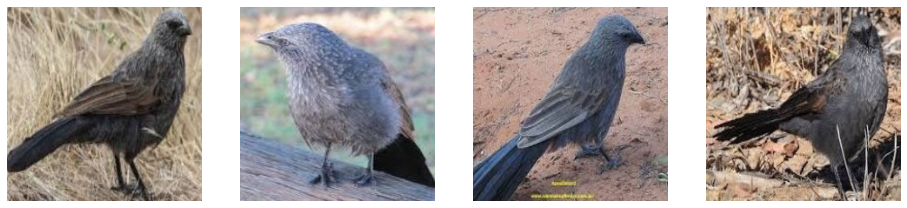

In [111]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(test_dataset[29*5+i][0].permute(1, 2, 0)  )

Przy wyjaśnieniach skupimy się na dwóch gatunkach - `American Redstart` i `Andean Siskin`. Oba są dobrze rozróżnialne dla człowieka, i jesteśmy w stanie zkwantyfikować poszczególne cechy świadczące o przynależności danego osobnika do tego gatunku (np. pomarańczowe plamy dla Redstart, żółto-czarne upierzenie dla Siskin).

W analizie wykorzystamy także trzeci gatunek ptaka - `Apostlebird`. Jest on znacząco różny od tych które chcemy rozważać, a sieć jest w stanie go z dużą pewnością odróżnić. Posłuży nam to za baseline do zrozumienia wyjaśnień - wyjaśnienia związane z tą klasą powinny być bezsensowne. Wzorce które zauważymy także na tej klasie będą nieistotne w rozważanym przez nas problemie, i będą głównie spowodowane ludzką tendencją do widzenia wzorców które niekoniecznie muszą istnieć.

# Wyjaśnienia modelu

In [112]:
def crossCompare(func, classA=18, classB=22, classC=29):
  fig, ax = plt.subplots(6, 4, figsize=(14,21))
  classNames = test_dataset.getclassnames()
  
  def inner(i, j, a):
    ax[a, 0].imshow(explanation[0][i][j].permute(1, 2, 0))
    ax[a, 0].axis('off')
    ax[a, 0].set_title(explanation[1][i])

    func(explanation[0][i][j], classA, (fig, ax[a, 1]))
    func(explanation[0][i][j], classB, (fig, ax[a, 2]))
    func(explanation[0][i][j], classC, (fig, ax[a, 3]))

    pred = (model(to_device(explanation[0][i][j].double().unsqueeze(0), DEVICE)))[0]
    ax[a, 1].set_title("Explanation: {0}\nProbability: {1:.2f}%".format(classNames[classA], pred[classA]*100))
    ax[a, 2].set_title("Explanation: {0}\nProbability: {1:.2f}%".format(classNames[classB], pred[classB]*100))
    ax[a, 3].set_title("Explanation: {0}\nProbability: {1:.2f}%".format(classNames[classC], pred[classC]*100))

  inner(0, 0, 0)
  inner(0, 1, 1)
  inner(3, 0, 2)
  inner(3, 1, 3)
  inner(1, 0, 4)
  inner(2, 0, 5)

  plt.show()

def shap(image, class_id, figure_ax):
    X = torch.clone(image).double()
    mask = segmentation.quickshift(
        X.permute(1, 2, 0).cpu(), 
        kernel_size=14, 
        max_dist=7, 
        ratio=0.5
      )
    
    explainer = KernelShap(model.double())
    explainer = explainer.attribute(
        to_device(X.unsqueeze(0), DEVICE),
        target=class_id, 
        n_samples=200, 
        feature_mask=to_device(torch.as_tensor(mask), DEVICE),
        show_progress=False
      )

    visualization.visualize_image_attr(
        explainer[0].permute(1, 2, 0).cpu().numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=False,
        plt_fig_axis=figure_ax,
        use_pyplot=False
    )

def ig(image, class_id, figure_ax):
    X = torch.clone(image).double()

    explainer = IntegratedGradients(model)
    explainer = explainer.attribute(
        to_device(X.unsqueeze(0), DEVICE),
        target=class_id, 
      )

    visualization.visualize_image_attr(
        explainer[0].permute(1, 2, 0).cpu().numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=False,
        plt_fig_axis=figure_ax,
        use_pyplot=False
    )
def lime(image, class_id, figure_ax):
    X = torch.clone(image).double()
    mask = segmentation.slic(
        X.permute(1, 2, 0).cpu().mean(axis=2), 
        n_segments=100, 
        compactness=0.1, 
        start_label=0
      )
    
    explainer = Lime(model.double())
    explainer = explainer.attribute(
        to_device(X.unsqueeze(0), DEVICE),
        target=class_id, 
        n_samples=2000, 
        feature_mask=to_device(torch.as_tensor(mask), DEVICE),
        show_progress=False
      )

    try:
      visualization.visualize_image_attr(
          explainer[0].permute(1, 2, 0).cpu().numpy(),
          method='heat_map',
          sign='all',
          show_colorbar=False,
          plt_fig_axis=figure_ax,
          use_pyplot=False
      )
    except:
      pass

## Shap

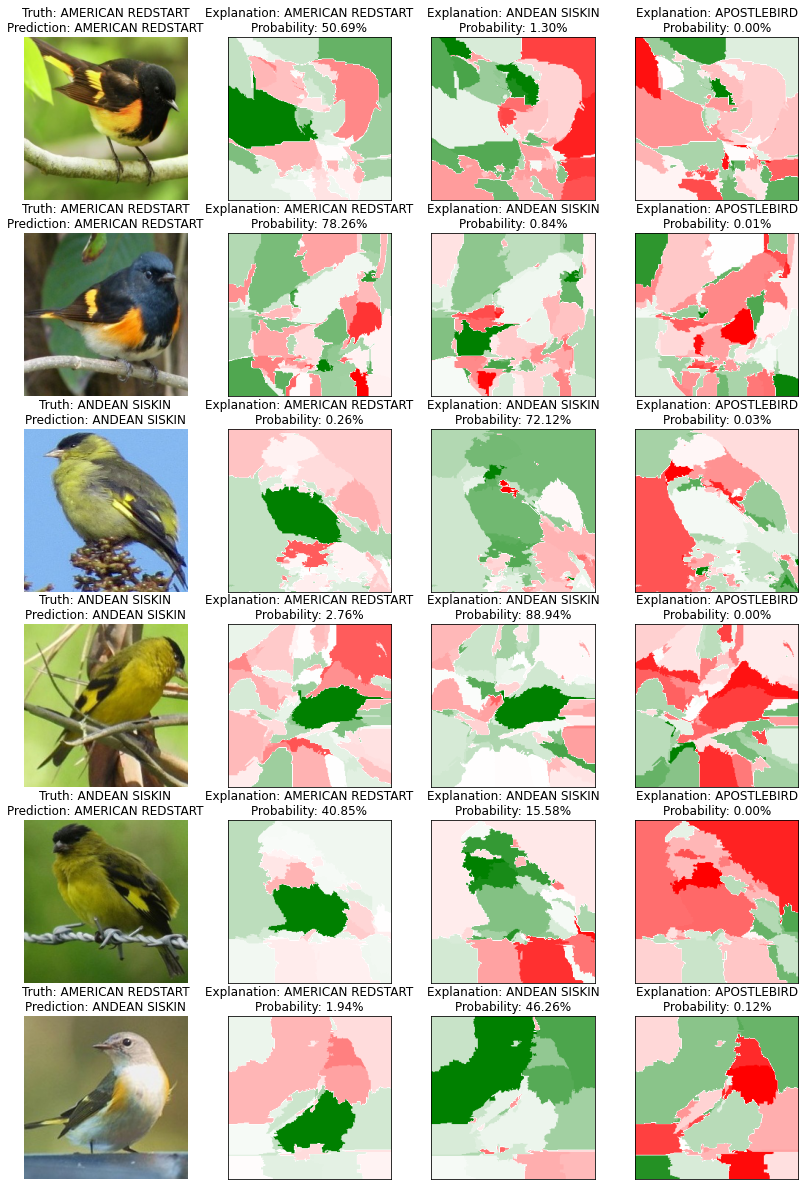

In [113]:
crossCompare(shap)

W przypadku poprawnie zaklasyfikowanych `American Redstart` widzimy duże znaczenie pomarańczowych plam w upierzeniu - jest to faktycznie cecha znacząca dla tego gatunku, więc jest to zachowanie wskazane.

W przypadku `Andean Siskin` też widać mocną zależność, sieć skupia się na jasno żółtym podbrzuszu ptaka. Ponownie, jest to cecha rozróżniająca, więc takie zachowanie jest wskazane.

Jednak w przypadku błędnych klasyfikacji zachowanie jest inne. Dla Siskina zaklasyfikowanego jako Redstart, duże znaczenie ma tło bezpośrednio pod ptakiem, prawdopodobnie gałąź na której miałby siedzieć. W przypadku drugiej błędnej klasyfikacji także widać że bardzo duże znaczenie ma tło, tutaj jednak trudniej domyślić się przyczyny tego zjawiska.

## Integrated Gradients

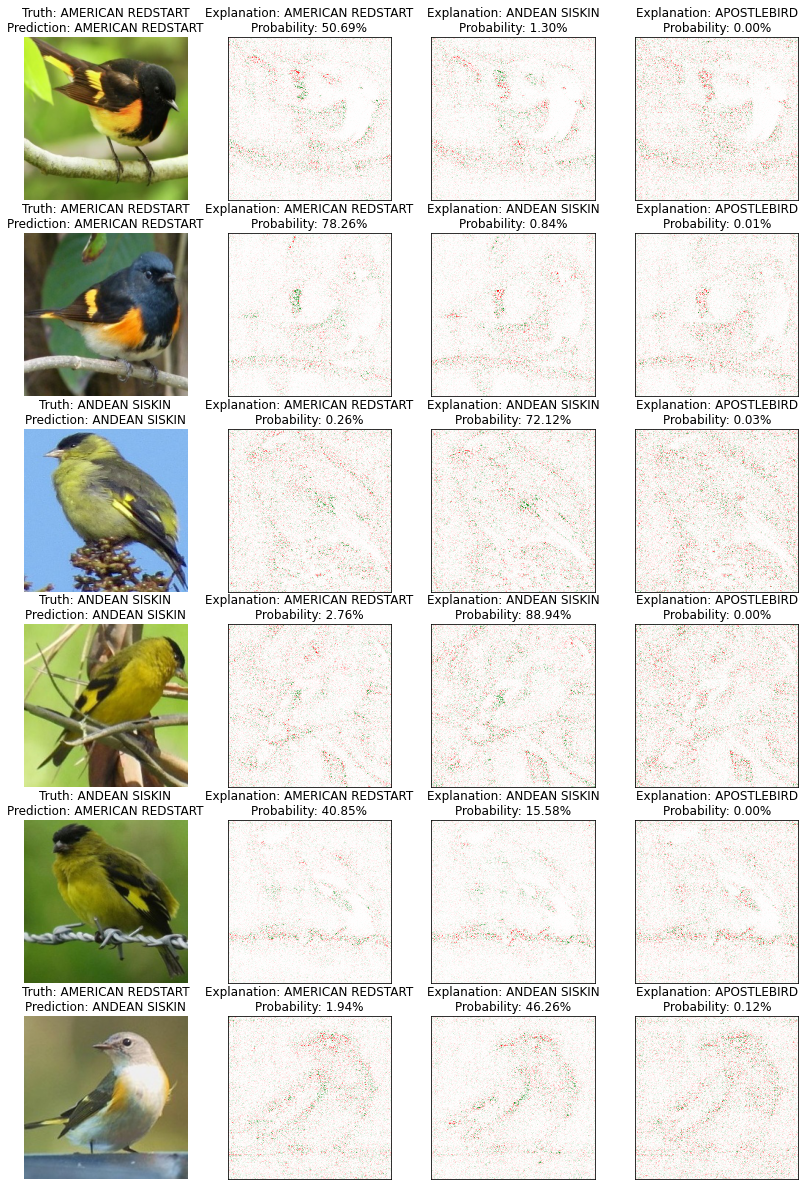

In [114]:
crossCompare(ig)

W porównaniu do metody shap, tutaj bardziej widoczne są plamy intensywnych kolorów w upierzeniu ptaków. Jednak wnioski co do poprawnych klasyfikacji zostają w dużej mierze takie same. 

W przypadku błędnych klasyfikacji trudniej zauważyć zależności z tłem które wcześniej zostały zaobserwowane. W przypadku `Andean Siskin` zaklasyfikowanego jako `American Redstart` widać tutaj duże znaczenie drutu na którym ptak się znajduje, co nie jest czymś co było widoczne w poprzednich wyjaśnieniach.

## Lime

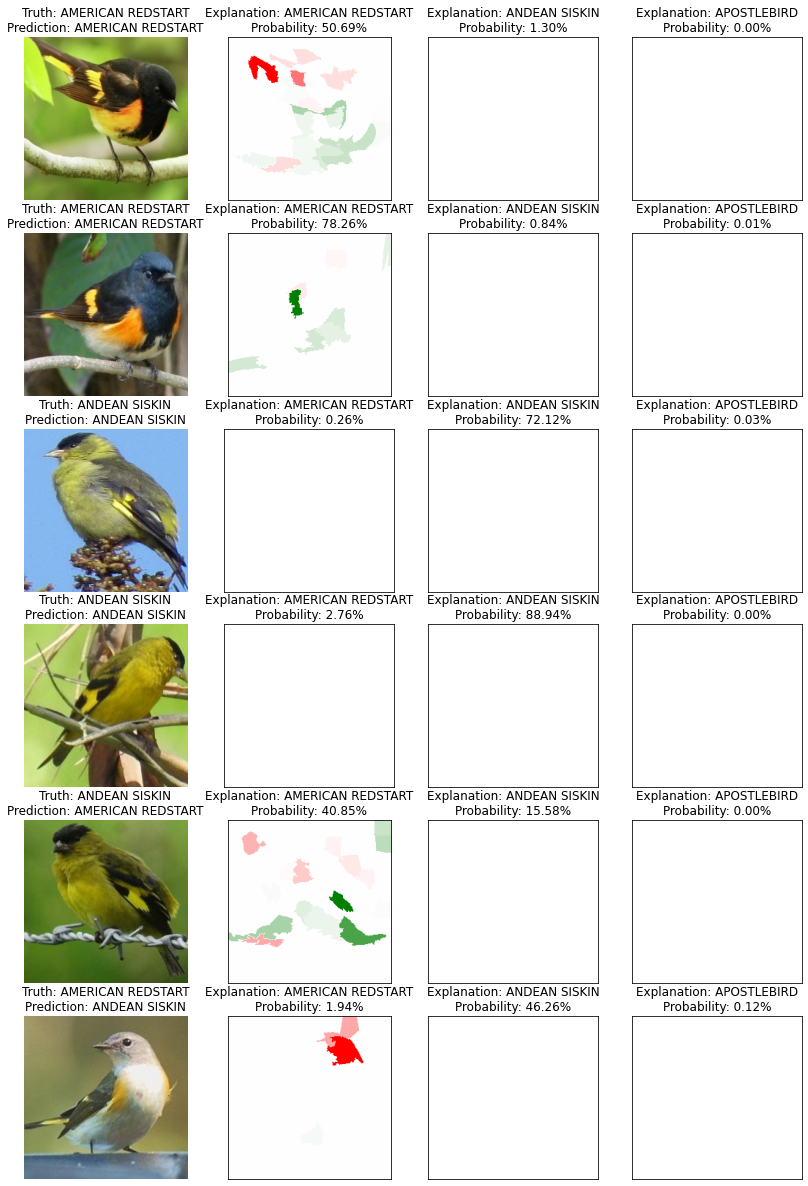

In [115]:
crossCompare(lime)

W porównaniu do dwóch poprzednich wyjaśnien, lime poradził sobie zdecydowanie najgorzej. Dla wielu ze zdjęć nie był wstanie utworzyć żadnego wyjaśnienia. Najprawdopodobniej jest to związane ze specyfiką problemu oraz wyborem zdjęć do wyjaśnienia. To co warto zauważyć to to, że wyjaśnienia wygenerowały się specyficznie dla zdjęć zaklasyfikowanych jako `American Redstart`.

Natomiast co do jakości wyjaśnień nie można być pewnym, widać pewne zależności które zostały potwierdzone poprzednimi dwoma metodami, jednak na typ etapie analizy może to być także bias obserwatora do potwierdzenia wcześniej wyciągniętych hipotez.